# Trunic OCR Demo Notebook

## How to use this
1. "Upload" a screenshot of Trunic text to this virtual filesystem
    - You can drag & drop into the file browser on the left or click the upload button
2. Change the string in the cell just below this to the path to the file you just uploaded
3. Click "Run" > "Run All Cells" in the top bar menu
4. Wait ~10-20 seconds

In [1]:
path_to_image = 'demo-data/manual 1.png'

#### hidden compute stuff

In [2]:
%pip install opencv-python

In [3]:
import math
from dataclasses import dataclass

import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

In [4]:
DEBUG = False
if DEBUG:
    from ipywidgets import interact, interactive
else:
    @dataclass
    class FakeInteractive:
        result: any

        def __repr__(self):
            return "FakeInteractive(...)"

    def interactive(func):
        return FakeInteractive(func())

    def interact(*args, **kwargs):
        pass


def mk_circle(diameter):
    return np.uint8(np.hypot(*np.ogrid[1-diameter:diameter:2, 1-diameter:diameter:2]) < diameter)


def mk_rect(x, y):
    return np.ones((y, x), dtype=np.uint8)

In [5]:
plt.rcParams['figure.figsize'] = (15, 9)

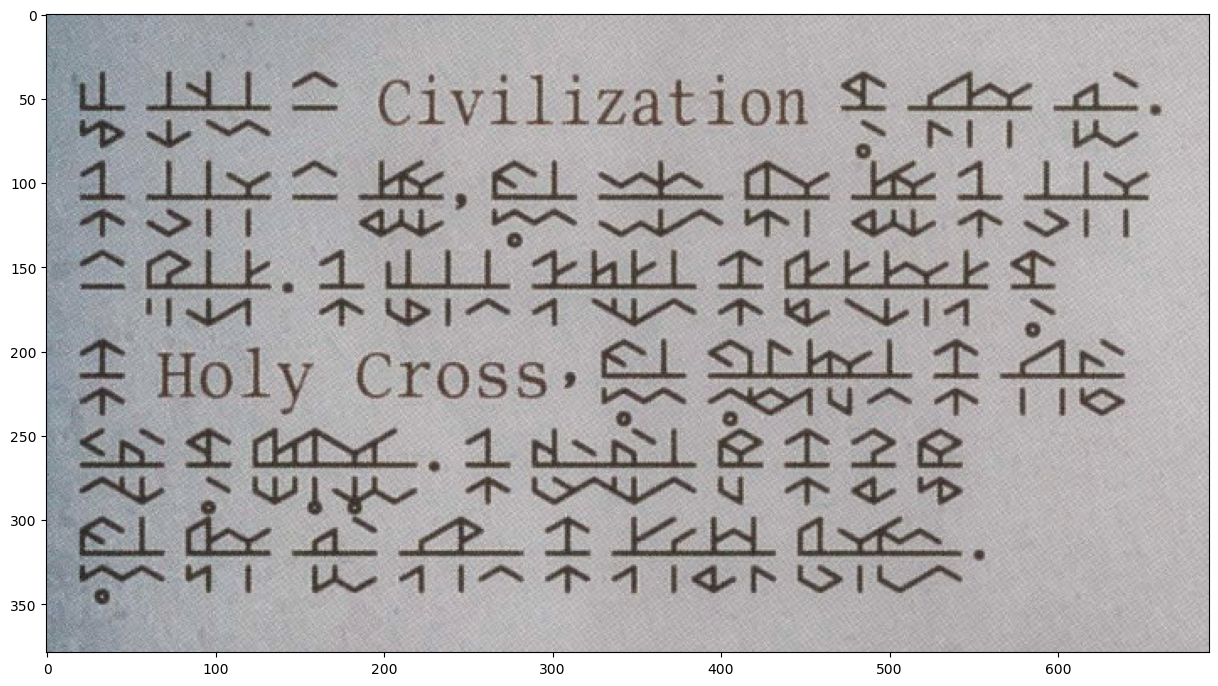

In [6]:
src_raw = cv2.imread(path_to_image)
plt.imshow(src_raw)

In [7]:
@interactive
def preprocess(upscale=3):
    src = cv2.resize(src_raw, None, None, upscale, upscale, cv2.INTER_CUBIC)
    src_gray = cv2.cvtColor(src, cv2.COLOR_RGBA2GRAY)
    if DEBUG:
        plt.imshow(src)
    return (src, src_gray, upscale)
preprocess

FakeInteractive(...)

In [8]:
src, src_gray, upscale = preprocess.result

In [9]:
@interactive
def segmentThreshold(blur=1, athresh_range_pct=30, athres_val=30):
    blurred = cv2.GaussianBlur(src_gray, (blur*2+1, blur*2+1), 0)
    thresh_block_size = round(min(blurred.shape[0], blurred.shape[1])*athresh_range_pct/200)*2+1
    thresh = cv2.adaptiveThreshold(
          blurred, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
          thresh_block_size, athres_val
    )
    avg_foregnd = np.mean(blurred[thresh > 0])
    thresh_inv = cv2.adaptiveThreshold(
          255 - blurred, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
          thresh_block_size, athres_val
    )
    avg_foregnd_inv = np.mean(blurred[thresh_inv > 0])
    border_avg = np.mean(np.concatenate([*blurred[:,[0,-1]], *blurred[[0,-1],:]]))
    ret = thresh_inv if abs(border_avg - avg_foregnd_inv) > abs(border_avg - avg_foregnd) else thresh
    ret = cv2.morphologyEx(ret, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (upscale, upscale)))
    if DEBUG:
        plt.imshow(ret)
    return ret
segmentThreshold

FakeInteractive(...)

In [10]:
strokes_raw = segmentThreshold.result

In [11]:
@interactive
def mkMedialAxis(laplacian_thresh=3.5):
    distTrans = cv2.distanceTransform(strokes_raw, cv2.DIST_L2, 5, dstType=cv2.CV_32F)
    distTransLp = cv2.Laplacian(distTrans, -1, ksize=3, scale=-1)
    _t, medialAxisMask = cv2.threshold(distTransLp, laplacian_thresh, 1, cv2.THRESH_BINARY)
    medialAxis = distTrans * medialAxisMask
    if DEBUG:
        # plt.imshow(src + cv2.cvtColor(cv2.normalize(medialAxis, None, 255, 0, cv2.NORM_INF, dtype=cv2.CV_8U), cv2.COLOR_GRAY2RGB))
        plt.imshow(medialAxis)
    return (medialAxis, np.uint8(medialAxisMask))
mkMedialAxis

FakeInteractive(...)

In [12]:
(medialAxis, medialAxisMask) = mkMedialAxis.result

In [13]:
stroke_h_width_max = math.ceil(np.max(medialAxis))
hist, hist_edges = np.histogram(medialAxis, (stroke_h_width_max - 1) * 2, (1.75, stroke_h_width_max+.75))
if DEBUG:
    plt.stairs(hist, hist_edges, fill=True)
stroke_width = np.argmax(hist) + 4
stroke_width

10

In [14]:
def cv2_cc_get_roi(cc_stats, i):
    x = cc_stats[i, cv2.CC_STAT_LEFT]
    y = cc_stats[i, cv2.CC_STAT_TOP]
    w = cc_stats[i, cv2.CC_STAT_WIDTH]
    h = cc_stats[i, cv2.CC_STAT_HEIGHT]
    return (slice(y, y+h), slice(x, x+w))


@interactive
def clean_strokes(area_ratio_min=2., stroke_filt_tol=4., stroke_filt_thresh_pct=65):
    n_comp, cc_labels, cc_stats, _c = cv2.connectedComponentsWithStats(strokes_raw, connectivity=4, ltype=cv2.CV_16U)

    strokes_clean = strokes_raw.copy()
    for i in range(1, n_comp):
        roi = cv2_cc_get_roi(cc_stats, i)
        if cc_stats[i, cv2.CC_STAT_AREA] < stroke_width * stroke_width * area_ratio_min:
            strokes_clean[roi][cc_labels[roi] == i] = 0
            continue
        comp_medial_axis = medialAxis[roi] * (cc_labels[roi] == i)
        ma_px_count_total = np.count_nonzero(comp_medial_axis)
        lo = (stroke_width - stroke_filt_tol)/2
        hi = (stroke_width + stroke_filt_tol)/2
        ma_px_count_range = np.count_nonzero((lo <= comp_medial_axis) & (comp_medial_axis <= hi))
        if ma_px_count_range / ma_px_count_total < stroke_filt_thresh_pct/100:
            strokes_clean[roi][cc_labels[roi] == i] = 0
            continue
    if DEBUG:
        plt.imshow(src)
        plt.imshow(strokes_clean, alpha=.5)
    return strokes_clean
clean_strokes

FakeInteractive(...)

In [15]:
strokes = clean_strokes.result
strokes_f = np.float32(strokes)

In [16]:
@dataclass
class BaselineSpec:
    x: int
    y: int
    length: int

    def as_roi(self):
        return (slice(self.y, self.y+1), slice(self.x, self.x+self.length))


@interactive
def find_baselines(min_aspect_ratio=3.5, filter_thresh_pct=90):
    line_min_len = round(stroke_width * min_aspect_ratio)
    kernel_x = np.ones(line_min_len, dtype=np.float32)
    kernel_y = np.array([0] * (stroke_width//2) + [1] * stroke_width + [0] + [-2] * (stroke_width//2-1), dtype=np.float32)
    bslns_lower_edge = cv2.sepFilter2D(strokes_f, -1, kernel_x, kernel_y, anchor=((kernel_x.size-1)//2, (kernel_y.size-1)//2))
    _v, bslns_lower_edge = cv2.threshold(bslns_lower_edge, stroke_width * line_min_len * filter_thresh_pct/100, 1, cv2.THRESH_BINARY)
    bslns_lower_edge = np.uint8(bslns_lower_edge)

    kernel_x = np.ones(upscale, dtype=np.float32)
    kernel_y = np.array([-2] * (stroke_width//2-1) + [0] + [1] * stroke_width + [0] + [-2] * (stroke_width//2-1), dtype=np.float32)
    bslns_both_edge = cv2.sepFilter2D(strokes_f, -1, kernel_x, kernel_y, anchor=((kernel_x.size-1)//2, (kernel_y.size-1)//2))
    _v, bslns_both_edge = cv2.threshold(bslns_both_edge, stroke_width * upscale * filter_thresh_pct/100, 1, cv2.THRESH_BINARY)
    bslns_both_edge = np.uint8(bslns_both_edge)
    bslns_lower_edge &= cv2.dilate(bslns_both_edge, cv2.getStructuringElement(cv2.MORPH_RECT, (2*stroke_width, 3)))

    bslns_lower_edge_dil = cv2.dilate(bslns_lower_edge, cv2.getStructuringElement(cv2.MORPH_RECT, (line_min_len, 3)))
    bslns_lower_edge_dil = cv2.morphologyEx(bslns_lower_edge_dil, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (stroke_width, 1)))

    bslns_seed = np.zeros(strokes_f.shape, dtype=np.uint8)
    n_cc, cc_labels, cc_stats, _c = cv2.connectedComponentsWithStats(bslns_lower_edge_dil)
    baselines_spec = []
    for i in range(1, n_cc):
        roi = cv2_cc_get_roi(cc_stats, i)
        cc_mask = cc_labels[roi] == i
        summed_l = np.sum(bslns_lower_edge[roi] & cc_mask, axis=1, dtype=np.uint32)
        summed_u = np.sum(bslns_both_edge[roi] & cc_mask, axis=1, dtype=np.uint32)
        line_y = np.argmax(summed_l + 3 * summed_u)

        spec = BaselineSpec(roi[1].start + 1 + math.floor((stroke_width - 1)/2), roi[0].start + line_y, cc_stats[i, cv2.CC_STAT_WIDTH] - 1 - stroke_width)
        baselines_spec.append(spec)
        bslns_seed[spec.as_roi()] = 1

    baselines = cv2.dilate(bslns_seed, mk_circle(stroke_width))
    if DEBUG:
        plt.imshow(src)
        plt.imshow(baselines, alpha=.5)
    return baselines, bslns_seed, baselines_spec
find_baselines

FakeInteractive(...)

In [17]:
baselines, baseline_seeds, baselines_spec = find_baselines.result

In [18]:
@interactive
def find_stroke_angle(hough_thresh=15):
    # also works fine with just `medialAxisMask`, but this looks cleaner
    lines = cv2.HoughLinesP(medialAxisMask * strokes, 1, math.pi / 180, hough_thresh, None, 0, 3)
    x1, y1, x2, y2 = lines.reshape((-1, 4)).transpose()
    dx = x2-x1
    dy = y2-y1
    lens = np.hypot(dx, dy)
    angles = np.int8(np.round(np.arctan2(dy, dx) * (36 / math.pi)))  # round to nearest 5 degrees
    angles = np.abs(angles)
    angles[angles > 18] -= 36
    angles = np.abs(angles)
    angles_hist, angles_hist_edges = np.histogram(angles, 19, (-.5, 18.5), weights=lens)
    stroke_angle_i = np.argmax(angles_hist[3:-3]) + 3
    stroke_angle = stroke_angle_i * 5

    if DEBUG:
        # probably too much effort for just pretty plot
        plt_grid = GridSpec(1, 4)
        ax = plt.subplot(plt_grid[0])
        ax.stairs(angles_hist, angles_hist_edges * 5, fill=True)
        ax.bar(stroke_angle, angles_hist[stroke_angle_i], 5, color='#0f0')
        ax = plt.subplot(plt_grid[1:4])
        ax.imshow(src)
        m = angles == stroke_angle_i
        nm = ~m
        ax.plot((x1[nm], x2[nm]), (y1[nm], y2[nm]), color='#fff')
        ax.plot((x1[m], x2[m]), (y1[m], y2[m]), color='#0f0')

    return stroke_angle
find_stroke_angle

FakeInteractive(...)

In [19]:
stroke_angle = find_stroke_angle.result
stroke_angle

30

In [20]:
@interactive
def find_vertical_segments(min_aspect_ratio=2., filter_area_thresh_pct=75, filter_edge_thresh_pct=70):
    def find(strokes_f, strokes, min_aspect_ratio, filter_area_thresh_pct, filter_edge_thresh_pct, bridge_zone=None):
        segment_min_len = round(stroke_width * min_aspect_ratio)
        img_fill_filt = cv2.boxFilter(strokes_f, -1, (stroke_width, segment_min_len), anchor=((stroke_width-1)//2, (segment_min_len-1)//2), normalize=False)
        seeds = np.uint8(img_fill_filt >= stroke_width * segment_min_len * filter_area_thresh_pct/100)
        seeds = cv2.dilate(seeds, cv2.getStructuringElement(cv2.MORPH_RECT, (1, segment_min_len)))
        seeds &= strokes

        kxcw = stroke_width-2
        kernel_x = np.array([-kxcw/2, 0, 0] + [1] * kxcw + [0, 0, -kxcw/2], dtype=np.float32)
        kernel_y = np.ones(upscale, dtype=np.float32)
        img_edge_filt = cv2.sepFilter2D(strokes_f, -1, kernel_x, kernel_y, anchor=((kernel_x.size-1)//2, (kernel_y.size-1)//2))
        seeds_edge = np.uint8(img_edge_filt >= filter_edge_thresh_pct/100 * kxcw * upscale)
        seeds &= cv2.dilate(seeds_edge, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3*stroke_width)))
        seeds &= cv2.erode(np.uint8(img_edge_filt >= 0), cv2.getStructuringElement(cv2.MORPH_RECT, (1, upscale)))

        if bridge_zone is not None:
            bridge_close = cv2.morphologyEx(seeds, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3*stroke_width)))
            seeds |= bridge_close & bridge_zone
            seeds = cv2.morphologyEx(seeds, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3*stroke_width + segment_min_len)))
        else:
            seeds = cv2.morphologyEx(seeds, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (1, segment_min_len)))

        seeds_clean = np.zeros(strokes_f.shape, dtype=np.uint8)
        n_cc, cc_labels, cc_stats, _c = cv2.connectedComponentsWithStats(cv2.dilate(seeds, mk_rect(3, 3)))
        coords = np.zeros((2, 2, n_cc-1), dtype=np.uint32)
        for i in range(1, n_cc):
            roi = cv2_cc_get_roi(cc_stats, i)
            cc_mask = cc_labels[roi] == i
            summed_f = np.sum(img_fill_filt[roi] * cc_mask, axis=0)
            summed_e = np.sum(img_edge_filt[roi] * cc_mask, axis=0)
            line_x = np.argmax(summed_f + 3 * (segment_min_len/upscale) * summed_e)

            x = roi[1].start + line_x
            y = roi[0].start + 1 + math.floor((stroke_width - 1)/2)
            height = cc_stats[i, cv2.CC_STAT_HEIGHT] - 1 - stroke_width
            seeds_clean[y:y+height, x] = 1
            coords[:, 0, i-1] = x
            coords[0, 1, i-1] = y
            coords[1, 1, i-1] = y + height-1

        return seeds_clean, coords

    bridge_zone = cv2.dilate(baselines, cv2.getStructuringElement(cv2.MORPH_RECT, (1, stroke_width*2)), anchor=(0, stroke_width*2-1))
    seeds_clean, coords = find(strokes_f, strokes, min_aspect_ratio, filter_area_thresh_pct, filter_edge_thresh_pct, bridge_zone)
    vertical_segments = cv2.dilate(seeds_clean, mk_circle(stroke_width))

    if DEBUG:
        plt.imshow(src)
        plt.imshow(vertical_segments, alpha=.5)
    return vertical_segments, coords, find
find_vertical_segments

FakeInteractive(...)

In [21]:
segments_raw_vert, segment_coords_raw_vert, func_find_segments = find_vertical_segments.result

In [22]:
@interactive
def find_slanted_segments(min_aspect_ratio=2.5, filter_area_thresh_pct=80, filter_edge_thresh_pct=90):
    width = strokes.shape[1]
    height = strokes.shape[0]

    def do_one(angle):
        angle_abs_r = abs(angle*math.pi/180)
        mat = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
        new_width = math.ceil(width * math.cos(angle_abs_r) + height * math.sin(angle_abs_r))
        new_height = math.ceil(height * math.cos(angle_abs_r) + width * math.sin(angle_abs_r))
        mat[0, 2] += (new_width-width)/2
        mat[1, 2] += (new_height-height)/2
        strokes_rot = cv2.warpAffine(strokes_f, mat, (new_width, new_height), flags=cv2.INTER_LINEAR)

        seeds_clean_rot, coords_rot = func_find_segments(strokes_rot, np.uint8(strokes_rot != 0), min_aspect_ratio, filter_area_thresh_pct, filter_edge_thresh_pct)

        segs_rot = cv2.dilate(seeds_clean_rot, mk_circle(stroke_width))
        segs_unrot = cv2.warpAffine(segs_rot, mat, (width, height), flags=(cv2.WARP_INVERSE_MAP | cv2.INTER_NEAREST))
        seeds_unrot = cv2.warpAffine(seeds_clean_rot, mat, (width, height), flags=(cv2.WARP_INVERSE_MAP | cv2.INTER_NEAREST))
        coords_unrot = np.matmul(np.linalg.inv(np.vstack((mat, np.array([0, 0, 1])))), np.insert(coords_rot, 2, 1, axis=1))
        return segs_unrot, seeds_unrot, np.delete(coords_unrot, 2, axis=1)

    segs_pos, seeds_pos, coords_pos = do_one(90 - stroke_angle)
    segs_neg, seeds_neg, coords_neg = do_one(stroke_angle - 90)
    if DEBUG:
        plt.imshow(src)
        plt.imshow(segs_pos | segs_neg, alpha=.5)
    return segs_pos, coords_pos, segs_neg, coords_neg
find_slanted_segments

FakeInteractive(...)

In [23]:
segments_raw_slant_p, segment_coords_raw_slant_p, segments_raw_slant_n, segment_coords_raw_slant_n = find_slanted_segments.result

In [24]:
all_segments_raw = segments_raw_vert | segments_raw_slant_p | segments_raw_slant_n
if DEBUG:
    plt.imshow(src)
    plt.imshow(all_segments_raw, alpha=.5)

In [25]:
def cv_rect_to_roi(r):
    return (slice(r[1], r[1]+r[3]), slice(r[0], r[0]+r[2]))


@interactive
def find_approx_glyph_height(percentile=95):
    dist_baseline = np.uint32(cv2.distanceTransform(~(baselines*255), cv2.DIST_C, 3))

    strokes_notbl = strokes & all_segments_raw

    dist_nbs, nbs_vrnoi = cv2.distanceTransformWithLabels(~(strokes_notbl*255), cv2.DIST_C, 3)

    dist_bline_ccmax = np.zeros(strokes.shape)
    for i in range(np.min(nbs_vrnoi), np.max(nbs_vrnoi)+1):
        vrnoi_mask_raw = nbs_vrnoi == i
        roi = cv_rect_to_roi(cv2.boundingRect(np.uint8(vrnoi_mask_raw)))
        vrnoi_mask = vrnoi_mask_raw[roi]
        dist_bline_ccmax[roi][vrnoi_mask] = np.max(dist_baseline[roi][vrnoi_mask & (strokes_notbl[roi] != 0)])
    dists = dist_bline_ccmax[baselines != 0]

    dists_min, ret, dists_max = np.int32(np.percentile(dists, [0, percentile, 100]))

    if DEBUG:
        # yay(?) more pretty graphs
        plt_grid = GridSpec(2, 4)
        ax = plt.subplot(plt_grid[:, 0])
        ax.hist(dists, bins=dists_max-dists_min+1, range=(dists_min-.5, dists_max+.5), density=True)
        ax.ecdf(dists-1, compress=True)  # plt bug??
        ax.axhline(percentile/100, color='#0f0')
        ax.axvline(ret, color='#0f0')
        ax = plt.subplot(plt_grid[0, 1:4])
        ax.imshow(src)
        ax.imshow(dist_bline_ccmax * baselines, alpha=.5)
        ax = plt.subplot(plt_grid[1, 1:4])
        ax.imshow(src)
        ax.imshow(cv2.dilate(baselines, cv2.getStructuringElement(cv2.MORPH_RECT, (1, ret*2))), alpha=.5)

    return ret
find_approx_glyph_height

FakeInteractive(...)

In [26]:
approx_glyph_height = find_approx_glyph_height.result
approx_glyph_height

66

In [27]:
all_endpoints = np.concatenate((*segment_coords_raw_vert, *segment_coords_raw_slant_p, *segment_coords_raw_slant_n), axis=1)
print(all_endpoints.shape)

if DEBUG:
    tmp_img = np.zeros(strokes.shape, dtype=np.uint8)
    tmp_img[*(np.int32(np.rint(all_endpoints))[::-1])] = 1
    plt.imshow(src)
    plt.imshow(cv2.dilate(tmp_img, mk_circle(stroke_width//2)), alpha=.5)

(2, 850)


In [28]:
# fourier tranform, sort of
def check_grid_fit(points, spacings):
    assert len(points.shape) == 1
    spacings = np.asarray(spacings)
    f = (1/spacings)[np.newaxis, ...]
    p = points.reshape(*points.shape, *((1,)*len(spacings.shape)))
    ft = np.sum(np.exp((2j*np.pi*f)*p), axis=0)
    return np.abs(ft) / points.size, np.angle(ft) * (spacings / (2*np.pi))


def filter_in_baseline(all_endpoints, bsln_spec):
    hsw0 = math.floor((stroke_width-1)/2)
    hsw1 = math.floor(stroke_width/2)
    xmin = bsln_spec.x - hsw0 - upscale
    xmax = bsln_spec.x + hsw1 + upscale + bsln_spec.length
    ymin_u = bsln_spec.y - hsw0 - upscale - approx_glyph_height
    ymax_l = bsln_spec.y + hsw1 + upscale + approx_glyph_height
    mask_all = (xmin <= all_endpoints[0]) & (all_endpoints[0] < xmax) & (ymin_u <= all_endpoints[1]) & (all_endpoints[1] < ymax_l)
    endpoints = all_endpoints[:, mask_all]
    endpoints -= [[bsln_spec.x], [bsln_spec.y]]
    return endpoints[:, endpoints[1] < -(hsw0 + upscale)], endpoints[:, hsw1 + upscale <= endpoints[1]]


@interactive
def find_geometry1(samples_per_check=50):
    a = np.deg2rad(stroke_angle)
    xform = np.array([[np.cos(a), np.cos(a)], [-np.sin(a), np.sin(a)]])
    xform_inv = np.linalg.inv(xform)

    all_endpoints_u = []
    all_endpoints_l = []
    for bsln_spec in baselines_spec:
        endpoints_u, endpoints_l = filter_in_baseline(all_endpoints, bsln_spec)
        all_endpoints_u.extend([endpoints_u, endpoints_u + [[bsln_spec.length-1],[0]]])
        all_endpoints_l.extend([endpoints_l, endpoints_l + [[bsln_spec.length-1],[0]]])
    all_endpoints_o_u = np.matmul(xform_inv, np.hstack(all_endpoints_u))
    all_endpoints_o_l = np.matmul(xform_inv, np.hstack(all_endpoints_l))

    def find_spacing():
        # upper limit for grid spacing; each word must contain at least one grid square
        bsln_min_length = np.quantile([b.length for b in baselines_spec], .25, method='closest_observation')
        spacing0 = xform_inv[0, 0] * bsln_min_length

        # assume spacing is at least `stroke_width`
        for spacing_div in range(1, math.ceil(spacing0/stroke_width) + 1):
            spacing = spacing0 / spacing_div
            spacings = np.linspace(spacing - upscale, spacing + upscale, num=samples_per_check)
            fits_u_x, offsets_u_x = check_grid_fit(all_endpoints_o_u[0], spacings)
            fits_l_x, offsets_l_x = check_grid_fit(all_endpoints_o_l[0], spacings)
            fits_u_y, offsets_u_y = check_grid_fit(all_endpoints_o_u[1], spacings)
            fits_l_y, offsets_l_y = check_grid_fit(all_endpoints_o_l[1], spacings)
            fits_all = (fits_u_x + fits_l_x + fits_u_y + fits_l_y) / 4
            print(fits_all)
            m = np.argmax(fits_all)
            if fits_all[m] > .8:
                return spacings[m], np.array([offsets_u_x[m], offsets_u_y[m]]), np.array([offsets_l_x[m], offsets_l_y[m]])

    spacing_o, offset_o_u, offset_o_l = find_spacing()

    def find_origin(all_endpoints_o, offset_o):
        gridpoints = np.int16(np.rint((all_endpoints_o - np.array(offset_o)[:, np.newaxis]) / spacing_o))
        gp_pr_bl = gridpoints[0] - gridpoints[1]
        gp_pr_bl_min = np.min(gp_pr_bl)
        gp_pr_bl_max = np.max(gp_pr_bl)
        offset_n_counts, offset_n_edges = np.histogram(gp_pr_bl, bins=range(gp_pr_bl_min, max(gp_pr_bl_max, gp_pr_bl_min+2)+2))  # ensure at least 3 bins
        offset_n_vals = offset_n_edges[:-1]
        offset_n_even_mask = offset_n_vals % 2 == 0
        max_i = np.argmax(np.convolve(offset_n_counts, [1,1,1], mode='same')[offset_n_even_mask])
        offset_n = offset_n_vals[offset_n_even_mask][max_i] // 2
        return offset_o + [offset_n * spacing_o, offset_n * -spacing_o]

    offset_o_u = find_origin(all_endpoints_o_u, offset_o_u)
    offset_o_l = find_origin(all_endpoints_o_l, offset_o_l)

    grid1, grid2, offset_u, offset_l = np.matmul(xform, np.array([[spacing_o, 0], [0, spacing_o], offset_o_u, offset_o_l]).T).T

    def refine_offset_x():
        vert_seg_x = np.concatenate([np.hstack(filter_in_baseline(np.float64(segment_coords_raw_vert[0]), bsln_spec))[0] for bsln_spec in baselines_spec])
        if len(vert_seg_x) > 0:
            _fit, offset = check_grid_fit(vert_seg_x, grid1[0])
            return offset
        else:
            return np.nanmean([offset_u[0], offset_l[0]])

    offset_x = refine_offset_x()
    offset_u[0] = offset_x
    offset_l[0] = offset_x

    if DEBUG:
        tmp_img = src.copy()
        pu00 = offset_u
        pu10 = pu00 + grid1
        pu01 = pu00 + grid2
        pu11 = pu00 + grid1 + grid2
        pl00 = offset_l
        pl10 = pl00 + grid1
        pl01 = pl00 + grid2
        pl11 = pl00 + grid1 + grid2
        polylines = [[pu00, pu01, pu11, pu10], [pl00, pl01, pl11, pl10], [pu00, pl00], [pu10, pl01], [[0,0], grid1+grid2]]
        polylines = [np.array(o).reshape((-1, 1, 2)) for o in polylines]
        glyph_width = grid1[0]*2
        for bsln_spec in baselines_spec:
            for i in range(round(bsln_spec.length/glyph_width)):
                glyph_orig = [bsln_spec.x + i*glyph_width, bsln_spec.y]
                cv2.polylines(tmp_img, [np.int32(o + glyph_orig) for o in polylines], True, (0,255,0), lineType=cv2.LINE_AA)
        plt.imshow(tmp_img)

    return grid1, grid2, offset_u, offset_l
find_geometry1

[0.79948738 0.82049529 0.84035452 0.85896056 0.87622106 0.89205583
 0.90639679 0.91918783 0.93038458 0.93995418 0.94787487 0.95413567
 0.95873592 0.96168482 0.96300088 0.96271145 0.96085208 0.95746597
 0.95260336 0.94632093 0.93868115 0.92975167 0.91960471 0.90831641
 0.89596627 0.88263649 0.86841144 0.85337706 0.83762034 0.82122874
 0.80428972 0.78689023 0.76911626 0.75105238 0.73278131 0.71438352
 0.69593685 0.67751614 0.65919289 0.64103492 0.62310609 0.605466
 0.58816969 0.57126746 0.55480459 0.53882116 0.52335193 0.50842616
 0.49406755 0.48029424]


FakeInteractive(...)

In [29]:
grid1, grid2, offset_u, offset_l = find_geometry1.result
glyph_width = grid1[0]*2
glyph_height = offset_l[1] - offset_u[1] + grid2[1]*2
glyph_width, glyph_height

(70.77307753312573, 126.79540813042242)

In [30]:
glyph_template_shape = (math.ceil(glyph_height) + 3*stroke_width + upscale*2, math.ceil(glyph_width) + stroke_width + upscale*2,)
glyph_template_origin = np.array([stroke_width//2 + upscale, (math.ceil(glyph_height) + stroke_width)//2 + upscale], dtype=np.uint32)


def make_template():
    pu00 = offset_u
    pu10 = pu00 + grid1
    pu01 = pu00 + grid2
    pu11 = pu00 + grid1 + grid2
    pl00 = offset_l
    pl10 = pl00 + grid1
    pl01 = pl00 + grid2
    pl11 = pl00 + grid1 + grid2
    all_lines = [
        [[pu00, [pu00[0],0]], [pl00 + [0,grid1[1]], pl00]],
        [[pu00, pu10]],
        [[pu00, pu01]],
        [[pl00, pl10]],
        [[pl00, pl01]],
        [[pu10, [pu10[0],0]]],
        [[pu01, [pu01[0],0]], [pl10, pl01]],
        [[pu10, pu11]],
        [[pu01, pu11]],
        [[pl10, pl11]],
        [[pl01, pl11]],
        [],
        [[[0,0], [glyph_width,0]]]
    ]
    glyph_template_uint8 = np.zeros((13, *glyph_template_shape), dtype=np.uint8)
    for canvas, polyline in zip(glyph_template_uint8, all_lines):
        cv2.polylines(canvas, [np.int32(2**16 * (o + glyph_template_origin)) for o in polyline], False, 255, thickness=stroke_width, lineType=cv2.LINE_AA, shift=16)
    cv2.circle(glyph_template_uint8[-2], np.int32(2**16 * (pl01 + [0, stroke_width] + glyph_template_origin)), 2**16 * (stroke_width-1), 255, thickness=stroke_width-1, lineType=cv2.LINE_AA, shift=16)
    glyph_template = np.float32(glyph_template_uint8) / 255
    for canvas in glyph_template:
        cv2.GaussianBlur(canvas, (3,3), 0, dst=canvas)

    glyph_lines = np.zeros((13, *glyph_template_shape), dtype=np.uint8)
    for canvas, polyline in zip(glyph_lines, all_lines):
        cv2.polylines(canvas, [np.int32(2**16 * (o + glyph_template_origin)) for o in polyline], False, 255, thickness=upscale, lineType=cv2.LINE_AA, shift=16)
    cv2.circle(glyph_lines[-2], np.int32(2**16 * (pl01 + [0, stroke_width] + glyph_template_origin)), 2**16 * (stroke_width-1), 255, thickness=upscale, lineType=cv2.LINE_AA, shift=16)

    template_overlap_uint8 = np.zeros(glyph_template_shape, dtype=np.uint8)
    cv2.polylines(template_overlap_uint8, [np.int32(2**16 * (o + glyph_template_origin + [glyph_width,0])) for lines in all_lines for o in lines], False, 255, thickness=stroke_width, lineType=cv2.LINE_AA, shift=16)
    cv2.polylines(template_overlap_uint8, [np.int32(2**16 * (o + glyph_template_origin - [glyph_width,0])) for lines in all_lines for o in lines], False, 255, thickness=stroke_width, lineType=cv2.LINE_AA, shift=16)
    template_overlap = np.float32(template_overlap_uint8) / 255
    cv2.GaussianBlur(template_overlap, (3,3), 0, dst=template_overlap)

    return glyph_template, template_overlap, glyph_lines

glyph_template, template_overlap, glyph_lines = make_template()
glyph_template_mask = glyph_template != 0
glyph_template_s = glyph_template[:-1]
glyph_template_mask_s = glyph_template_mask[:-1]

if DEBUG:
    plt_grid = GridSpec(1, 2)
    interact(lambda i: (plt.subplot(plt_grid[:,0]).imshow(glyph_template[i], cmap='gray'),plt.subplot(plt_grid[:,1]).imshow(template_overlap, cmap='gray')), i=(0, len(glyph_template)-1))

In [31]:
def make_glyph_template_base():
    all_glyphs = np.max(glyph_template_s, axis=0)
    glyph_template_base = -all_glyphs
    glyph_template_base[glyph_template_mask[-1]] = glyph_template[-1][glyph_template_mask[-1]]
    template_overlap_mask = template_overlap > 0
    glyph_template_base[template_overlap_mask] = np.fmax(glyph_template_base[template_overlap_mask], 0)
    return glyph_template_base
glyph_template_base = make_glyph_template_base()

if DEBUG:
    plt.imshow(glyph_template_base)

In [32]:
def gen_template_data(strokes):
    template_data = glyph_template_base.copy()
    mask = glyph_template_mask[-1] | np.any(glyph_template_mask_s[strokes], axis=0)
    template_data[mask] = np.fmax(template_data[mask], np.max(glyph_template_s[strokes], axis=0)[mask])
    return template_data


def gen_templates_data(strokes):
    template_data = np.repeat(glyph_template_base[np.newaxis, ...], len(strokes), axis=0)
    what = glyph_template_mask_s[np.newaxis, ...] * strokes[..., np.newaxis, np.newaxis]
    mask = glyph_template_mask[-1] | np.any(what, axis=1)
    template_data[mask] = np.fmax(template_data[mask], np.max(glyph_template_s[np.newaxis, ...] * strokes[..., np.newaxis, np.newaxis], axis=1)[mask])
    return template_data


def gen_next_templates_strokes(template_strokes: np.ndarray):
    def w(a,i): a[i]=True; return a
    return np.array([w(template_strokes.copy(), i) for i in np.nonzero(~template_strokes)[0]], dtype=np.bool_)


def check_template(glyphs_all_offsets, templates_data):
    tmpl_dt_max0 = np.fmax(templates_data, 0)
    best_offsets_i = np.argmax(np.einsum("ikl,jkl->ji", glyphs_all_offsets, tmpl_dt_max0), axis=1)
    best_offsets = all_template_offsets[best_offsets_i]
    glyphs = glyphs_all_offsets[best_offsets_i]
    return np.einsum("ijk,ijk->i", glyphs, templates_data) / np.sum(tmpl_dt_max0, axis=(1,2)), best_offsets


def glyph_slice_par(offsets):
    strokes_bordered = cv2.copyMakeBorder(strokes, stroke_width, stroke_width, stroke_width, stroke_width, cv2.BORDER_CONSTANT, value=0)
    offsets = offsets + [stroke_width, stroke_width]
    return np.array([strokes_bordered[offset[1]:, offset[0]:][:glyph_template_shape[0], :glyph_template_shape[1]] for offset in offsets])

all_template_offsets = np.dstack(np.mgrid[:5,:5]).reshape(-1, 2) - 2


def fit_glyph(glyph_origin):
    glyphs_all_offsets = glyph_slice_par(all_template_offsets + (glyph_origin - glyph_template_origin))
    current_template_strokes = np.zeros(len(glyph_template_s), dtype=np.bool_)
    current_template_data = glyph_template_base.copy()
    current_fit, current_offset = check_template(glyphs_all_offsets, current_template_data[np.newaxis, ...])
    for _i in range(len(glyph_template_s)):
        next_templates_strokes = gen_next_templates_strokes(current_template_strokes)
        fits, offsets = check_template(glyphs_all_offsets, np.array([gen_template_data(t) for t in next_templates_strokes]))
        next_i = np.argmax(fits)
        if fits[next_i] < current_fit:
            break
        current_template_strokes = next_templates_strokes[next_i]
        current_fit = fits[next_i]
        current_offset = offsets[next_i]
    return current_template_strokes, current_offset + glyph_origin


glyphs = [[
    fit_glyph(np.array([round(bsln_spec.x + i*glyph_width), bsln_spec.y], dtype=np.int32))
    for i in range(round(bsln_spec.length/glyph_width))
] for bsln_spec in baselines_spec]


if DEBUG:
    tmp_img = np.zeros(strokes.shape)
    for bsln_list in glyphs:
        for glyph_tmpl_strokes, glyph_tmpl_offset in bsln_list:
            offset = glyph_tmpl_offset - glyph_template_origin
            tmp_img_slice = tmp_img[offset[1]:, offset[0]:][:glyph_template_shape[0], :glyph_template_shape[1]]
            tmp_img_slice[...] = np.fmax(tmp_img_slice, gen_template_data(glyph_tmpl_strokes))
    plt.imshow(src)
    plt.imshow(tmp_img, alpha=.3)

In [33]:
vowel_strokes = np.array([7,1,0,4,10], dtype=np.uint8)
cnsnt_strokes = np.array([8,5,2,3,6,9], dtype=np.uint8)

In [34]:
vowels = [
    ([1,1,1,0,0], "æ"),
    ([0,1,1,0,0], "ɒ", ["ɑː"]),
    ([0,0,0,1,1], "ɪ", ["i"]),
    ([0,0,1,1,1], "ɛ", ["e"]),
    ([0,0,1,1,0], "ʊ", ["u"]),
    ([1,1,0,0,0], "ə", ["ʌ"]),
    ([0,1,1,1,1], "iː", ["i"]),
    ([1,1,1,1,0], "uː", ["u"]),
    ([1,0,1,1,1], "ər", ["ʌr", "ɜːr"]),
    ([1,1,1,0,1], "ʊər", ["ʊr", "ɔːr"]),
    ([1,1,0,1,1], "ɒr", ["ɑːr"]),
    ([0,1,1,0,1], "ɪər", ["ɪr"]),
    ([0,1,0,0,0], "eɪ"),
    ([1,0,0,0,0], "aɪ"),
    ([0,0,0,1,0], "ɔɪ"),
    ([0,0,0,0,1], "aʊ"),
    ([1,1,1,1,1], "oʊ"),
    ([0,0,1,0,1], "ɛər", ["ɛr", "ær"]),
    ([0,0,0,0,0], ""),
]

In [35]:
consonants = [
    ([0,0,0,1,0,1], "m"),
    ([0,0,1,1,0,1], "n"),
    ([1,1,1,1,1,1], "ŋ"),
    ([1,0,0,0,1,0], "p"),
    ([0,1,0,0,0,1], "b"),
    ([1,0,1,0,1,0], "t"),
    ([0,1,0,1,0,1], "d"),
    ([1,1,0,0,0,1], "k"),
    ([1,0,0,0,1,1], "ɡ"),
    ([0,1,0,1,0,0], "dʒ"),
    ([0,0,1,0,1,0], "tʃ"),
    ([1,0,0,1,1,0], "f"),
    ([0,1,1,0,0,1], "v"),
    ([1,1,1,0,1,0], "θ"),
    ([0,1,0,1,1,1], "ð"),
    ([1,1,0,1,1,0], "s"),
    ([0,1,1,0,1,1], "z"),
    ([1,0,1,1,1,1], "ʃ"),
    ([1,1,1,1,0,1], "ʒ"),
    ([0,1,0,0,1,1], "h"),
    ([1,1,0,0,1,0], "r"),
    ([0,1,1,0,1,0], "j"),
    ([1,0,1,0,0,0], "w"),
    ([0,1,0,0,1,0], "l"),
    ([0,0,0,0,0,0], ""),
]

In [36]:
vowels_lut = np.full((2,)*5, -1, dtype=np.int8)
for i, vowel in enumerate(vowels):
    vowels_lut[*vowel[0]] = i
cnsnt_lut = np.full((2,)*6, -1, dtype=np.int8)
for i, cnsnt in enumerate(consonants):
    cnsnt_lut[*cnsnt[0]] = i


def glyph2ipa(glyph_strokes):
    vowel_i = vowels_lut[*np.uint8(glyph_strokes[vowel_strokes])]
    if vowel_i < 0:
        return '?'
    cnsnt_i = cnsnt_lut[*np.uint8(glyph_strokes[cnsnt_strokes])]
    if cnsnt_i < 0:
        return '?'
    if not glyph_strokes[11]:
        return consonants[cnsnt_i][1] + vowels[vowel_i][1]
    else:
        return vowels[vowel_i][1] + consonants[cnsnt_i][1]


def transcribe():
    lines_img = np.zeros(src.shape[:2], dtype=np.uint8)
    for word in glyphs:
        for glyph_strokes, glyph_offset in word:
            plt.text(*glyph_offset, glyph2ipa(glyph_strokes), bbox=dict(fc="#fff8", ec="#0000"))
            offset = glyph_offset - glyph_template_origin
            lines_img_slice = lines_img[offset[1]:, offset[0]:][:glyph_template_shape[0], :glyph_template_shape[1]]
            lines_img_slice[...] = np.fmax(lines_img_slice, np.max(glyph_lines[[*glyph_strokes, True]], axis=0))
    plt.imshow(src)
    plt.imshow(lines_img[..., np.newaxis] * [0,1/255,0,1/(2*255)])

## OUTPUT

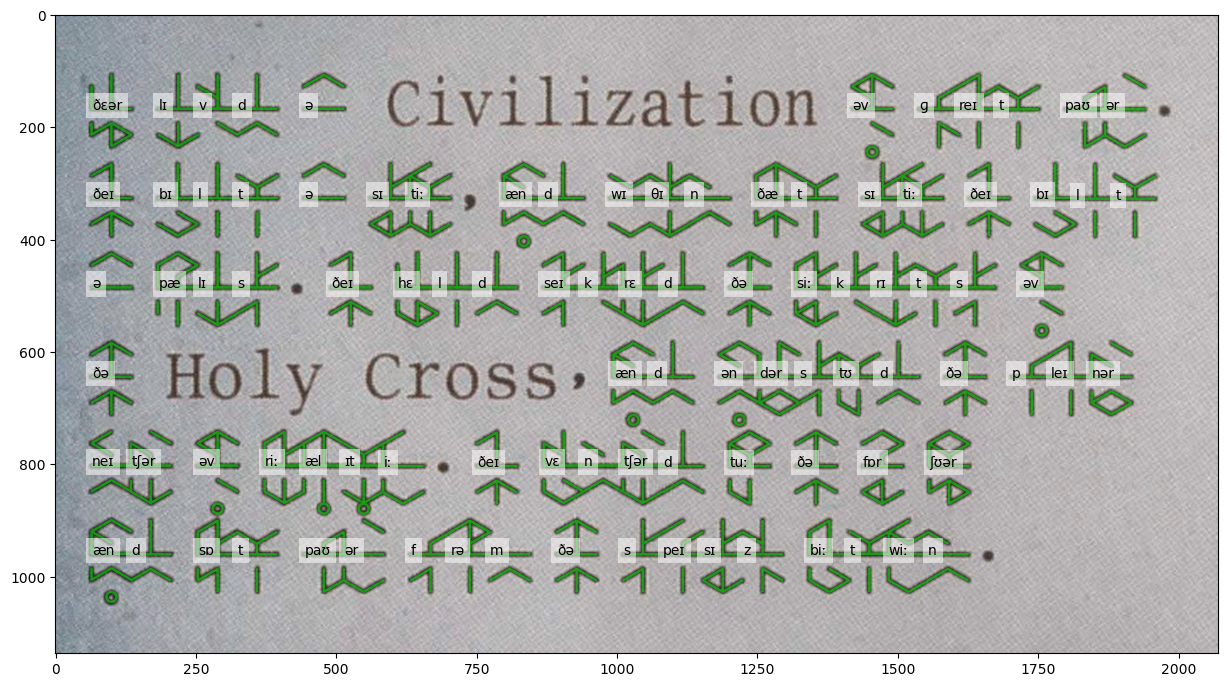

In [37]:
transcribe()